In [ ]:
##TODO LIST
# Gọi các thư viện
# Tải tập dữ liệu
# xử lý dữ liệu rỗng
# xử lý dữ liệu đối tượng


In [ ]:
#Gọi các thư viện (Import the libaries)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder

In [1]:
import graphviz
import itertools
import matplotlib.pyplot as plt # graphing with insane defaults
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # graphing with sane defaults
import scipy.stats as stats
import sklearn.linear_model as linear_model
from sklearn.base import BaseEstimator
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold
import sklearn.preprocessing as preprocessing # Preprocess data (e.g. scale numerical data to 0-1
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from termcolor import colored, cprint
import typing # Apply common types to objects)
from yellowbrick.features import PCA as yellowPCA

feature_engineering = typing.TypeVar('rabbitml.feature_engineering')


#Xây dựng lớp tiền xử lý dữ liệu 
class rabbitml:
    """
    An automl library designed for tabular data

    @Taran Sean Marley 
    https://www.kaggle.com/taranmarley
    """
    class feature_engineering:
        """
        A class intended to move through and improve the features of a dataset.
        """
        
        def auto_casefold(self, df : pd.DataFrame) -> pd.DataFrame:
            """
            Take a dataframe, find the string columns and convert them all to lower case through casefold

            Parameters
            ----------
            dataframe : pd.DataFrame
                The dataframe to casefold over to convert to lower case

            Returns
            -------
            pd.DataFrame
                The same dataframe given with the new lorrrwer case values if applied

            """
            for col in df.columns:
                if self.is_string_type(df[col]):
                    df[col] = df[col].astype(str).str.casefold()
            return df

        def break_up_by_string(self, df_temp : pd.DataFrame, splitting_string : str) -> pd.DataFrame:
            """
            Break up columns by string to create new columns from each split.

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to start splitting up object columns
            splitting_string : str
                String to split up columns by


            Returns
            -------
            pd.DataFrame
                modified dataframe with extra columns containing split up values
            """
            obj_cols = df_temp.select_dtypes(include=[object])
            # count spaces
            for col in obj_cols:
                if df_temp[col].str.contains(splitting_string).sum() > 0:
                    df2 = df_temp[col].str.split(splitting_string, expand=True)
                    # Rename columns
                    rename_dict = {}
                    for rename_col in df2.columns:
                        if (splitting_string != " "):
                            rename_dict[rename_col] = col + splitting_string + str(rename_col)
                        else:
                            rename_dict[rename_col] = col + str(rename_col)
                    df2 = df2.rename(columns=rename_dict)
                    df2 = df2.fillna(0)
                    df_temp = pd.concat([df_temp,df2], axis=1) 
            return df_temp
        
        def compare_object_columns(self, df_temp : pd.DataFrame, df_temp_2 : pd.DataFrame, silent = False, replace = False) -> None:
            """
            Compare object columns and print out the if there is a difference between them. This helps determining the differences between a test dataframe and a training dataframe
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                First dataframe to compare columns with
            df_temp_2 : pd.DataFrame
                Second dataframe to compare columns with
            silent : bool
                Print the results or not
            replace : bool
                Replace bad values in df_temp with NaN values
            """
            for col in df_temp.select_dtypes(include="object").columns:
                if col in df_temp_2.columns:
                    unique_df_list = df_temp[col].unique().tolist()
                    test_df_list = df_temp_2[col].unique().tolist()
                    if set(unique_df_list) != set(test_df_list):
                        unique_df_list = ["nan" if x is np.nan else x for x in unique_df_list]
                        test_df_list = ["nan" if x is np.nan else x for x in test_df_list] 
                        unique_df_list.sort()
                        test_df_list.sort()
                        # Print lists if requested
                        if not silent:
                            print("***",col)
                            print(unique_df_list)
                            print(test_df_list)
                        # Replace with NaN if requested by parameter 
                        for x in unique_df_list:
                            if x not in test_df_list:
                                df_temp[col].replace({x:np.nan})

        def create_interactions(self, df_temp : pd.DataFrame, column_list : typing.List) -> pd.DataFrame:
            """
            Create interactions by totalling and multiplying columns within a dataframe

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to create interactions in
            column_list : typing.List
                List of columns to create interactions from

            Returns
            ----------
            pd.DataFrame
                Dataframe with interactions added
            """
            # Cross wise multiplication interactions
            for x in itertools.combinations(column_list, 2):
                df_temp[x[0]+"_X_"+x[1]] = df_temp[x[0]] * df_temp[x[1]]
                df_temp = df_temp.copy()
            # Iterative Totals
            iterative_total = 0
            i = 0
            for j in (column_list):
                iterative_total = iterative_total + df_temp[j]
                if i > 0:
                    df_temp["A" + str(i) + "_iter_score"] = iterative_total
                    df_temp = df_temp.copy()
                i = i + 1
            return df_temp
            
        def detect_continous_columns(self, df_temp : pd.DataFrame, ratio : float = 0.05, continous_columns : typing.List = []) -> typing.List:
            """
            Detect the continous columns in a dataframe. Columns that have more than the given ratio by total length of dataframe will be considered continous.

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to detect continous columns in. This is assumed to already be encoded to a numerical format
            ratio : float / int
                Ratio of the total length of dataframe that will be used to cull continous from discrete data, if given as an int then this is consider to be a discrete number instead of a ratio
            continous_columns : typing.List
                Continous columns that can be given to the function without checking

            Returns
            ----------
            typing.List
                List of columns found
            """
            continous_cutoff : int = round(ratio * len(df_temp))
            if ratio > 1:
                continous_cutoff = ratio
            for col in df_temp.columns:
                if not self.is_string_type(df_temp[col]):
                    if col not in continous_columns:
                        if df_temp[col].nunique() > continous_cutoff:
                            continous_columns.append(col)
            return continous_columns

        def detect_duplicates(self, df_temp : pd.DataFrame, silent : bool = False, id_cols : typing.List = []) -> None: 
            """
            Detect duplicates in data and return the columns in which duplicates where detected.

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to detect duplicates in
            silent : bool
                Whether to run print statements 
            id_cols : typing.List
                Given id cols that aren't auto detected - Useful if there is an obvious ID column that also wants to be detected for duplication
            """
            # Filter out identity columns
            cols_to_use = []
            for col in df_temp.columns:
                if len(df_temp[col].unique()) != len(df_temp[col]):
                    cols_to_use.append(col)
                elif col not in id_cols:
                    id_cols.append(col)
            id_temp = df_temp.copy()[id_cols]
            df_temp = df_temp.copy()[cols_to_use]    
            count_dupes = df_temp.duplicated().sum()
            count_dupes_in_ID = id_temp.duplicated().sum()
            if not silent:
                print('Duplicates in data: ', str(count_dupes))
                print('Duplicates in id columns: ', str(count_dupes_in_ID))
                print('When filtering out id columns: ', str(id_cols))

        def detect_nans(self, df_temp : pd.DataFrame, name = '', silent : bool = False, plot : bool = True) -> typing.List:
            """
            Detect NaNs in a provided dataframe and return the columns that NaNs were detected in     

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to detect NaN values in
            name : str
                Name of the dataframe which helps give a more descriptive read out
            silent : bool
                Whether the print statements should fire
            plot : bool
                Whether to return a plot of the counts of NaNs in the data

            Returns
            -------
            typing.List
                List of columns in the provided dataframe that contain NaN values
            """
            plt.rcParams["figure.figsize"] = (9,9)
            
            count_nulls = df_temp.isnull().sum().sum()
            columns_with_NaNs = []
            # Count NaNs by column
            if count_nulls > 0:
                for col in df_temp.columns:
                    if df_temp[col].isnull().sum().sum() > 0:
                        columns_with_NaNs.append(col)
            # Print out the NaN values
            if not silent:            
                if name != '': 
                    print('******')
                    cprint('Detecting NaNs in ' + str(name), attrs=['bold'])
                    print('******')
                print('NaNs in data:', count_nulls)
                if count_nulls > 0:
                    print('******')
                    for col in columns_with_NaNs:
                        print('NaNs in', col + ": ", df_temp[col].isnull().sum().sum())
                    print('******')
            print('')
            # Plot the NaN values in columns in bar plot
            if plot and count_nulls > 0:
                sns.barplot(y=df_temp[columns_with_NaNs].isnull().sum().index, x=df_temp[columns_with_NaNs].isnull().sum().values).set_title(str(name) + " NaNs")
                plt.show()
            return columns_with_NaNs
        
        def detect_id_columns(self, df_temp : pd.DataFrame) -> typing.List:
            """
            Detect which columns are ID columns, those for which one unique value exists for each row.

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to detect ID columns

            Returns
            -------
            typing.List
                List of Identity columns that were detected
            """
            id_cols = []
            for col in df_temp.columns:
                if len(df_temp[col].unique()) == len(df_temp[col]):
                    id_cols.append(col)
            return id_cols

        def drop_unshared_columns(self, df_temp : pd.DataFrame, df_temp_2 : pd.DataFrame, exclude_columns : typing.List) -> None:
            """
            Detect which columns are not shared between the two dataframes excepting for a target_col if provided.
            Delete in place.

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to check for shared columns        
            df_temp_2 : pd.DataFrame
                Second dataframe to check for shared columns
            exclude_columns : typing.List
                Columns not to remove in this process
            """    
            drop_cols : typing.List = []
            for col in df_temp_2.columns:
                if col not in df_temp.columns:
                    if col not in exclude_columns:
                        drop_cols.append(col)
            df_temp_2.drop(columns=drop_cols, axis=1, inplace=True)
            drop_cols : typing.List = []
            for col in df_temp.columns:
                if col not in df_temp_2.columns:
                    if col not in exclude_columns:
                        drop_cols.append(col)
            df_temp.drop(columns=drop_cols, axis=1, inplace=True)
                        
        def encode_binary_object(self, series : pd.Series) -> pd.Series:
            """
            Encode a binary object series

            Parameters
            ----------
            series : pd.Series
                The series to be encoded. 

            Returns
            -------
            pd.Series
                The encoded series
            """
            map_dict = {}
            series_list = series.unique().tolist()
            series_list.sort()
            for i, x in enumerate(series_list):
                map_dict[x] = i
            series = series.map(map_dict)
            return series
        
        def encode_columns(self, df : pd.DataFrame, columns : pd.Series, test_df : pd.DataFrame = None, cutoff : int = 12) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
            """
            Encode columns based on the number of unique values in each column

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to encode columns in 
            columns : pd.Series
                Columns to encode
            test_df : pd.DataFrame
                Test dataframe to encode based on classes in the Dataframe
            cut_off : int
                The cut off number of classes to choose between label encoding and get dummies. This keeps the dimensionality under control

            Returns
            -------
            (pd.DataFrame, pd.DataFrame)
                Original dataframe and the test dataframe
            """    
            for col in columns:
                le = preprocessing.LabelEncoder()
                classes_to_encode = df[col].astype(str).unique().tolist()
                classes_to_encode.sort()
                classes_to_encode.append('None')
                le.fit(classes_to_encode)
                # Get dummies except for binary variables which are handled by len(le.classes) != 3
                if len(le.classes_) < cutoff and len(le.classes_) != 3:
                    df = pd.get_dummies(df, columns = [col])
                    if test_df is not None:
                        test_df = pd.get_dummies(test_df, columns = [col])
                else:
                    # First test for binary variables that should be encoded and change things if that is the case
                    binary_detected = False
                    if df[col].nunique() == 2 and df[col].isnull().sum().sum() == 0:
                        # Detect test_df exists and is binary and the unqiue values of test compare the unique values in regular df
                        if test_df is not None and test_df[col].nunique() == 2 and test_df[col].isnull().sum().sum() == 0 and set(test_df[col].unique()) == set(df[col].unique()): 
                            binary_detected = True
                        elif test_df is None:
                            binary_detected = True
                    if binary_detected:
                        classes_to_encode.remove('None')
                        le.fit(classes_to_encode)
                    # If no test dataframe encode as normal else we should clear out classes not found in test
                    if test_df is None:
                        df[col] = le.transform(df[col].astype(str))
                    else:
                        check_col = df.copy()[col]
                        #Clean out labels in train that aren't in test
                        input_dict = {}
                        for unique in df[col].unique():
                            if unique not in pd.unique(test_df[col]) and not binary_detected:
                                input_dict[unique] = 'None'
                        df[col] = df[col].replace(input_dict)                        
                        df[col] = le.transform(df[col].astype(str))
                        #Clean out unseen labels in test
                        input_dict = {}
                        for unique in test_df[col].unique():
                            if unique not in pd.unique(check_col) and not binary_detected:
                                input_dict[unique] = 'None'
                        test_df[col] = test_df[col].replace(input_dict)
                        test_df[col] = le.transform(test_df[col].astype(str))
            return df, test_df

        def fill_nans_create_columns(self, df_temp : pd.DataFrame, columns : typing.List, value : float = 0) -> pd.DataFrame:
            """
            Fill NaN of provided columns and create columns to signify they weren't there.

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to modify
            columns : typing.List
                Columns of the provided dataframe to modify
            value : float
                Value to replace the NaN values with

            Returns
            -------
            pd.DataFrame
                Modified Dataframe with NaNs filled and new columns signifying the rows that contained NaNs
            """
            for col in columns:
                df_temp[col + "_was_null"] = df_temp[col].isnull().astype(int)
                df_temp[col] = df_temp[col].fillna(value)
            return(df_temp)
        
        def is_string_type(self, series: pd.Series) -> bool:
            """
            Detect if a series contains is a string type 

            Parameters
            ----------
            series : pd.Series
                The series to detect the presence of a string type

            Returns
            -------
            bool
                Whether a string type was detected or not

            @Inspired by work by https://stackoverflow.com/users/3876599/yourstruly
            """
            if pd.StringDtype.is_dtype(series.dtype):
                # Is a string extension type
                return True

            if series.dtype != "object":
                # No object column - definitely not a string
                return False

            try:
                series.str
            except AttributeError:
                return False

            return True        

        def quantile_transform_column_wise(self, df_temp : pd.DataFrame, target_col : str = "") -> pd.DataFrame:
            """
            Transform values in dataframe to quantile uniform distribution

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to quantile transform 
            target_col : str
                This is the target col and is not transformed

            Returns
            -------
            pd.DataFrame
                Modified dataframe
            """    
            df_temp = df_temp.copy()
            # find n_samples
            n_samples : int = 1000
            if len(df_temp) < 1000:
                n_samples = len(df_temp)
            for col in df_temp.columns:
                if col != target_col:
                    transformed = preprocessing.QuantileTransformer(random_state=1, n_quantiles=n_samples).fit_transform(df_temp[col].values.reshape(-1, 1))
                    df_temp[col] = pd.Series(transformed[:,0], index=df_temp[col].index, name=df_temp[col].name)
            return df_temp
        
        def min_max_column_wise(self, df_temp : pd.DataFrame, target_col : str = ""):
            df_temp = df_temp.copy()
            for col in df_temp.columns:
                if col != target_col:
                    df_temp[col] = preprocessing.MinMaxScaler().fit_transform(df_temp[col].values.reshape(-1, 1))
            return df_temp
        
        def pipeline(self, df_temp : pd.DataFrame, test_df_temp : pd.DataFrame = None, target_col : str = None) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
            """
            A pipeline through which the data is processed and feature engineered
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to process features of 
            test_df_temp : pd.DataFrame
                The test dataframe to process features of 
            target_col : str
                The optional target column that won't be processed due to this being problematic for the end result
                
            Returns 
            -------
            (pd.DataFrame, pd.DataFrame)
                
            """
            df_temp = df_temp.copy()
            target = None
            if target_col != "":
                target = df_temp[target_col]
                df_temp = df_temp.drop(columns=target_col) 
            self.detect_nans(df_temp, "Training Data")
            self.fill_nans_create_columns(df_temp, df_temp.columns)
            self.detect_duplicates(df_temp)
            continous_columns = self.detect_continous_columns(df_temp, 20, continous_columns=[])
            self.create_interactions(df_temp, continous_columns).copy()
            # Process test dataframe if it exists
            if test_df_temp is not None:
                self.detect_nans(test_df_temp, "Testing Data" )
                self.fill_nans_create_columns(test_df_temp, test_df_temp.columns)
                self.detect_duplicates(test_df_temp)
                continous_columns = self.detect_continous_columns(test_df_temp,20, continous_columns=[])
                self.create_interactions(test_df_temp, continous_columns).copy()
            df_temp, test_df_temp = self.encode_columns(df_temp, df_temp.select_dtypes(include="object").columns, test_df_temp)
            # Detect Ids and remove them
            id_cols = self.detect_id_columns(df_temp)
            if id_cols is not None and len(id_cols) > 0:
                df_temp = df_temp.drop(columns=id_cols)
            if test_df_temp is not None:
                self.drop_unshared_columns(df_temp, test_df_temp, target_col)
            if target_col != "":
                df_temp[target_col] = target
            return df_temp, test_df_temp
        
    class eda:
        """
        A set of tools for Exploratory Data Analysis
        """

        def class_balance(self, df_temp : pd.DataFrame, target_col : str) -> None:
            """
            Display and show a plot of the target categorical value

            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to find class balance in 
            target_col : str
                Name of column with which to find the target categorical value
            """
            sns.countplot(x=df_temp[target_col])
            plt.show()
            column_values = df_temp[target_col].values.ravel()
            unique_values = pd.unique(column_values)
            unique_values = np.sort(unique_values)
            for value in unique_values:
                print(value,":",(len(df_temp.loc[df_temp[target_col] == value]) / len(df_temp)) * 100, "%")

        def pca_dimension_reduction_info(self, df_temp : pd.DataFrame, target_col : str) -> None:
            """
            Examine the results of dimensionality reduction on the dataset
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                DataFrame to conduct PCA on
            target_col : str
                target column to remove before conducting PCA         
            """
            df_temp = df_temp.copy()
            y = df_temp[target_col]
            X = df_temp.drop(columns=target_col, axis=1)
            X_scaled = preprocessing.MinMaxScaler().fit_transform(X)
            print(str(len(X_scaled[0])) + " initial feature components")
            pca = PCA(n_components=0.95)
            X_p = pca.fit(X_scaled).transform(X_scaled)
            print("95% variance explained by " + str(len(X_p[0])) + " components by principle component analysis")
            pca = PCA(n_components=3)
            X_p = pca.fit(X_scaled).transform(X_scaled)
            print(str(round(pca.explained_variance_ratio_.sum() * 100)) + "% variance explained by 3 components by principle component analysis")
            pca = PCA(n_components=2)
            X_p = pca.fit(X_scaled).transform(X_scaled)
            print(str(round(pca.explained_variance_ratio_.sum() * 100)) + "% variance explained by 2 components by principle component analysis")
        
        def pca_visualisation_2d(self, df_temp : pd.DataFrame, target_col : str) -> None:
            """
            Visualize 2d
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                The dataframe to use features from for embedding
            target_col : str
                The target variable to be dropped from dataframe
            """
            if len(df_temp) > 3000:
                df_temp = df_temp.copy().sample(n=2999, random_state=1)
            y = df_temp[target_col]
            X = df_temp.drop(columns=[target_col])
            visualizer = yellowPCA(scale=True, projection=2, alpha=0.4)
            visualizer.fit_transform(X, y)
            visualizer.show()
            plt.show()
            
        def pca_visualisation_3d(self, df_temp : pd.DataFrame, target_col : str) -> None:
            """
            Visualize 3d PCA embedding
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                The dataframe to use features from for embedding
            target_col : str
                The target variable to be dropped from dataframe
            """
            if len(df_temp) > 3000:
                df_temp = df_temp.copy().sample(n=2999, random_state=1)
            y = df_temp[target_col]
            X = df_temp.drop(columns=[target_col])
            visualizer = yellowPCA(scale=True, projection=3, alpha=0.4, size=(700,700))
            visualizer.fit_transform(X, y)
            visualizer.show()
            plt.show()
        
        def box_plots(self, df_temp : pd.DataFrame, columns : typing.List) -> None:
            """
            Make box plots of different continous columns
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to make box plots of
            columns : typing.List
                A list of continous columns to use
            """
            if len(columns) > 25:
                columns = columns[:25]
            fig = plt.figure(figsize = (15, 9))
            for index,col in enumerate(df_temp[columns]):
                plt.subplot(5, 5, index + 1)
                sns.boxplot(y = col, data = df_temp[columns])
                plt.tight_layout()
            plt.show()
        
        def line_plots(self, df_temp : pd.DataFrame, columns : typing.List) -> None:
            """
            Make line plots of different continous columns
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                Dataframe to make line plots of
            columns : typing.List
                A list of continous columns to use
            """    
            pltdf = df_temp.copy()
            pltdf = pltdf[columns]
            pltdf = pltdf.sample(frac=1, random_state=42).reset_index(drop=True)
            pltdf.iloc[:50, :25].plot(subplots=True, layout=(5,5), figsize=(15,10))
            plt.show()
        
        def calculate_correlations(self, df_temp : pd.DataFrame, target_col : str, n_cols : int = 10, silent : bool = False, visualise : bool = False) -> typing.List:
            """
            Calculate the pearson correlations between the target variable and the dataframe and returns columns that are beyond a certain ratio correlation 
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                dataframe to examine
            target_col : str
                the target column to measure correlation against
            n_cols : int
                number of columns to return, this amount of columns with the highest correlation
            silent : bool
                whether to print to console
            visualise : bool
                whether to display a heatmap of correlations
            """
            df_temp = df_temp.copy()
            if not silent:
                print("Correlations with",target_col + ":")
            # Generate correlation list
            correlations_list = []
            for col_one in df_temp.iloc[:,:].columns:
                correlation_value =  abs(df_temp[col_one].corr(df_temp[target_col]))
                # Check for NaN
                if (correlation_value == correlation_value):
                    correlations_list.append((correlation_value,col_one))
            # Sort List
            correlations_list = sorted(correlations_list, key=lambda tup: tup[0], reverse=True)
            # Go through list to find columns to return
            cols = []
            for i, row in enumerate(correlations_list):
                correlation = row[0]
                col = row[1]
                if i < n_cols:
                    cols.append(col)
                    # print the correlation
                    if not silent:
                        print(col, ":", correlation)            
            corrdf = df_temp.copy()
            corrdf = corrdf[cols].corr()
            sns.heatmap(abs(corrdf), cmap="Blues")
            return cols
        
        def pair_grid_plot(self, df_temp : pd.DataFrame, cols : typing.List) -> None:
            """
            Pair grid plots of given columns
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                Data to plot from
            cols : typing.List
                Columns to make a pairgrid from
            """
            g = sns.PairGrid(df_temp[cols].iloc[:500,:], diag_sharey=False)
            g.map_upper(sns.histplot, multiple="stack")
            g.map_lower(sns.kdeplot)
            g.map_diag(sns.kdeplot, lw=2)

        def decision_tree(self, df_temp : pd.DataFrame, depth : int, target_col : str, kind : str) -> None:
            """
            Draw a decision_tree from the given dataframe to the given depth and display it
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                The dataframe to create a decision tree from
            depth : int
                The depth of the decision tree to create
            target_col : str
                The target column to make a decision tree towards
            """
            tree_set = df_temp.copy()
            target = tree_set[target_col]
            tree_set.drop([target_col], axis=1, inplace=True)
            tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
            tree_clf.fit(tree_set, target)
            text_representation = tree.export_text(tree_clf, feature_names=tree_set.columns.tolist())
            print(text_representation)
            print("accuracy: " + str(tree_clf.score(tree_set, target)))    
            plt.rcParams["figure.figsize"] = (18,18)
            # tree.plot_tree(tree_clf, feature_names=tree_set.columns, filled=True)
            if kind == "categorical":
                class_column_values = df_temp[target_col].values.ravel()
                class_unique_values = pd.unique(class_column_values)
                class_unique_values = np.sort(class_unique_values)
                class_unique_values = class_unique_values.astype('str')
                le = preprocessing.LabelEncoder()
                target = le.fit_transform(target)
                dot_data = tree.export_graphviz(tree_clf, out_file=None, 
                                                feature_names=tree_set.columns,  
                                                class_names=class_unique_values,
                                                filled=True)
                return graphviz.Source(dot_data, format="png")
            return None
        
        def pipeline(self, df_temp, target_col : str, fe : feature_engineering, kind="categorical"):
            """
            A pipeline to apply a bunch of different EDA procedures against the 
            """
            if kind == "categorical":
                self.class_balance(df_temp, target_col)
                plt.show()
            else: 
                sns.displot(x=df_temp[target_col])
                plt.title("Class Balance")
                plt.show()
            print("***")
            cprint("Dimensional Reduction", attrs=['bold'])
            print("***")
            self.pca_dimension_reduction_info(df_temp, target_col)
            plt.show()
            self.pca_visualisation_2d(df_temp, target_col)
            plt.show()
            self.pca_visualisation_3d(df_temp, target_col)
            plt.show()
            print("***")
            cprint("Box Plots", attrs=['bold'])
            print("***")
            continous_columns = fe.detect_continous_columns(df_temp, 20, continous_columns=[])
            self.box_plots(df_temp, continous_columns)
            plt.show()
            print("***")
            cprint("Line Plots", attrs=['bold'])
            print("***")
            continous_columns = fe.detect_continous_columns(df_temp, 20, continous_columns=[])
            self.line_plots(df_temp, continous_columns)
            plt.show()
            print("***")
            cprint("Correlations", attrs=['bold'])
            print("***")
            scaled_df = fe.quantile_transform_column_wise(df_temp, target_col)
            correlations = self.calculate_correlations(df_temp, target_col, 10)
            plt.show()
            print("***")
            cprint("Pair Grid Plot", attrs=['bold'])
            print("***")
            self.pair_grid_plot(df_temp, self.calculate_correlations(df_temp, target_col, 5))
            plt.show()
            print("***")
            cprint("Decision Tree", attrs=['bold'])
            print("***")            
            tree_graph = self.decision_tree(df_temp, 2, target_col, kind)
            if tree_graph is not None:
                display(tree_graph)
                plt.show()
    
    class feature_selection:
        """
        Determine which features to use for training. 
        """
        def kendall_tau_feature_elimination(df_temp : pd.DataFrame, columns : typing.List, target_col : str, test_p_value : float = 0.001) -> typing.List:
            """
            Eliminate features that don't pass a Kendall Tau test in regards to the target variable. 
            This would tend to eliminate useless or unhelpful features from the dataset while retaining appropriate ones.
            A list of features the do pass the test is created and returned. 

            Should be used with continous columns only.
            
            Parameters
            ----------
            df_temp : pd.DataFrame
                DataFrame to conduct Kendall Tau on features 
            columns : typing.List
                A list of continous columns
            target_col : str
                Target column to conduct Kendall Tau towards
            test_p_value : float
                P value to test against. The sensitivity for 
                
            Returns
            -------
            typing.List
                features that passed the Kendall Tau features
            """
            new_features = []
            for feature in columns:
                tau, p_value = stats.kendalltau(df_temp[target_col], df_temp[feature])
                if p_value <= test_p_value:
                    new_features.append(feature)
            return new_features    
        # Chọn ra các thuộc tính 
        def select_from_model_features(df_temp: pd.DataFrame, target_col : str, estimator : BaseEstimator, threshold : float = None) -> typing.Tuple[typing.List, np.ndarray]:
            """
            Use a compatible sklearn estimator for determining a list of features that are important to the dataset

            Parameters
            ----------
            df_temp : pd.DataFrame
                dataframe to find the features in
            target_col : str
                the name of the target column so it can be selected
            estimator : BaseEstimator
                The sklearn estimator to fit on. Must have coef_
            threshold : float
                Threshold to decide which features to keep or not

            Returns
            -------
            typing.Tuple[typing.List, np.ndarray]
                List of features selected, array of the coefficients that have been selected
            """
            X = df_temp.drop(columns=target_col)
            y = df_temp[target_col]
            estimator.fit(X, y)
            model = SelectFromModel(estimator, threshold = threshold, prefit=True) 
            feature_names = np.array(df_temp.drop(columns=target_col).columns)
            return feature_names[model.get_support()].tolist(), model.estimator.coef_
    
    class prediction:
        """
        Create and compare predictors than analyse them
        """
        # hiển thị ma trận confusion
        def confusion_matrix_display(clf : BaseEstimator, X : np.ndarray, y : np.ndarray) -> None:
            """
            Shown the confusion matrix for a given sklearn estimator
            
            Parameters
            ----------
            clf : BaseEstimator
                The classifier to use for the confusion matrix
            X : np.ndarray
                The numpy array of features
            y : np.ndarray
                The numpy array of the target variable
            """
            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
            predictions = clf.predict(X_test)
            cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
            disp.plot()
            plt.grid(False)
            plt.show()

        # So sánh các giải thuật regression 
        def linear_classification_compare(X : np.ndarray, y : np.ndarray) -> typing.List:
            """
            Classify the target col using a number of linear classifiers
            
            Parameters
            ----------
            X : np.ndarray
                The features to use for classification
            y : np.ndarray
                The target to use the classifiers on
                
            Returns
            -------
            typing.List
                A list of classifiers that have been fitted on the data provided
            """
            classifiers = [("RidgeClassifier", linear_model.RidgeClassifier()), ("SGDClassifier", linear_model.SGDClassifier()), ("LogisticRegression", linear_model.LogisticRegression(solver="liblinear"))]
            classification_results = []
            kfold = KFold(n_splits=5)
            for entry in classifiers:
                name : str = entry[0]
                classifier = entry[1]
                scores = []
                for train_index, test_index in kfold.split(X, y):
                    classifier.fit(X[train_index], y[train_index])
                    scores.append(classifier.score(X[test_index], y[test_index]))
                classification_results.append((classifier, (sum(scores) / len(scores))))
                print(name, "Score:", sum(scores) / len(scores))        
            return classification_results

In [4]:
#Đọc dữ liệu (Read the dataset)
Train_data = pd.read_csv("train.csv")
Test_data = pd.read_csv("test.csv")
Sample_submission = pd.read_csv("sample_submission.csv")
Test_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


******
Detecting NaNs in Training Data
******
NaNs in data: 6965
******
NaNs in LotFrontage:  259
NaNs in Alley:  1369
NaNs in MasVnrType:  8
NaNs in MasVnrArea:  8
NaNs in BsmtQual:  37
NaNs in BsmtCond:  37
NaNs in BsmtExposure:  38
NaNs in BsmtFinType1:  37
NaNs in BsmtFinType2:  38
NaNs in Electrical:  1
NaNs in FireplaceQu:  690
NaNs in GarageType:  81
NaNs in GarageYrBlt:  81
NaNs in GarageFinish:  81
NaNs in GarageQual:  81
NaNs in GarageCond:  81
NaNs in PoolQC:  1453
NaNs in Fence:  1179
NaNs in MiscFeature:  1406
******



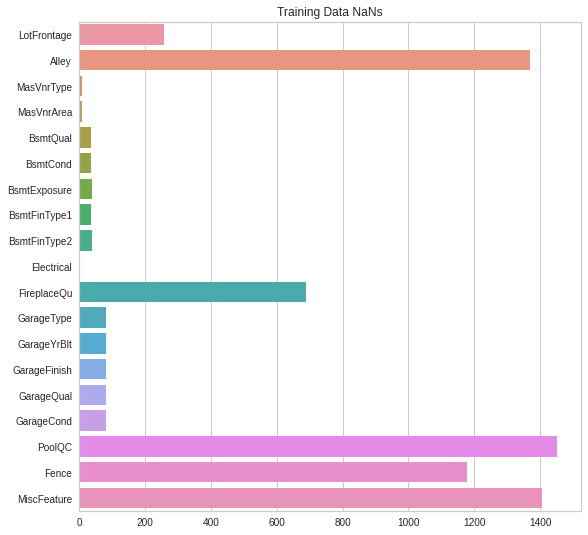

Duplicates in data:  0
Duplicates in id columns:  0
When filtering out id columns:  ['Id']
******
Detecting NaNs in Testing Data
******
NaNs in data: 7000
******
NaNs in MSZoning:  4
NaNs in LotFrontage:  227
NaNs in Alley:  1352
NaNs in Utilities:  2
NaNs in Exterior1st:  1
NaNs in Exterior2nd:  1
NaNs in MasVnrType:  16
NaNs in MasVnrArea:  15
NaNs in BsmtQual:  44
NaNs in BsmtCond:  45
NaNs in BsmtExposure:  44
NaNs in BsmtFinType1:  42
NaNs in BsmtFinSF1:  1
NaNs in BsmtFinType2:  42
NaNs in BsmtFinSF2:  1
NaNs in BsmtUnfSF:  1
NaNs in TotalBsmtSF:  1
NaNs in BsmtFullBath:  2
NaNs in BsmtHalfBath:  2
NaNs in KitchenQual:  1
NaNs in Functional:  2
NaNs in FireplaceQu:  730
NaNs in GarageType:  76
NaNs in GarageYrBlt:  78
NaNs in GarageFinish:  78
NaNs in GarageCars:  1
NaNs in GarageArea:  1
NaNs in GarageQual:  78
NaNs in GarageCond:  78
NaNs in PoolQC:  1456
NaNs in Fence:  1169
NaNs in MiscFeature:  1408
NaNs in SaleType:  1
******



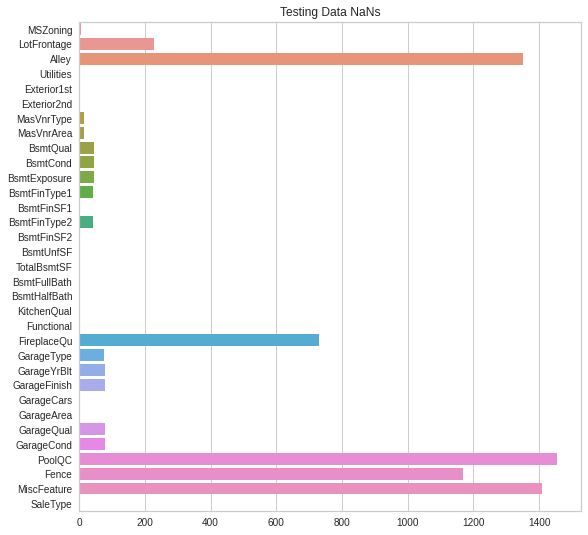

Duplicates in data:  0
Duplicates in id columns:  0
When filtering out id columns:  ['Id']


,MSSubClass,LotFrontage,LotArea,Street,Utilities,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,60,65.0,8450,1,0,5,7,5,2003,2003,...,0,0,1,0,0,0,0,1,0,208500
1,20,80.0,9600,1,0,25,6,8,1976,1976,...,0,0,1,0,0,0,0,1,0,181500
2,60,68.0,11250,1,0,5,7,5,2001,2002,...,0,0,1,0,0,0,0,1,0,223500
3,70,60.0,9550,1,0,6,7,5,1915,1970,...,0,0,1,1,0,0,0,0,0,140000


In [6]:
#Process Data 
# Hiển thị các thông tin: dữ liệu NAN, dữ liệu trùng và vẽ lên đồ thị
fe = rabbitml.feature_engineering()
Train_data,Test_data = fe.pipeline(Train_data,Test_data,target_col='SalePrice')
Train_data.head(4)

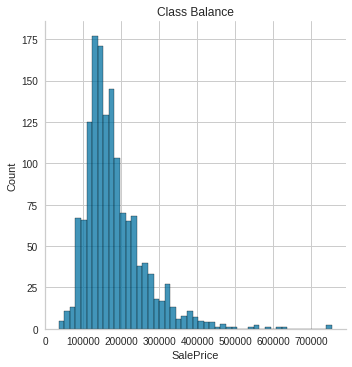

***
Dimensional Reduction
***
314 initial feature components
95% variance explained by 83 components by principle component analysis
26% variance explained by 3 components by principle component analysis
21% variance explained by 2 components by principle component analysis


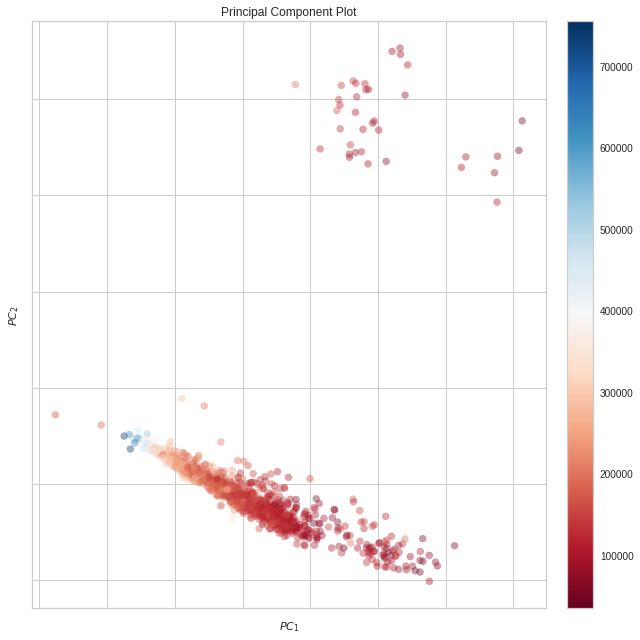

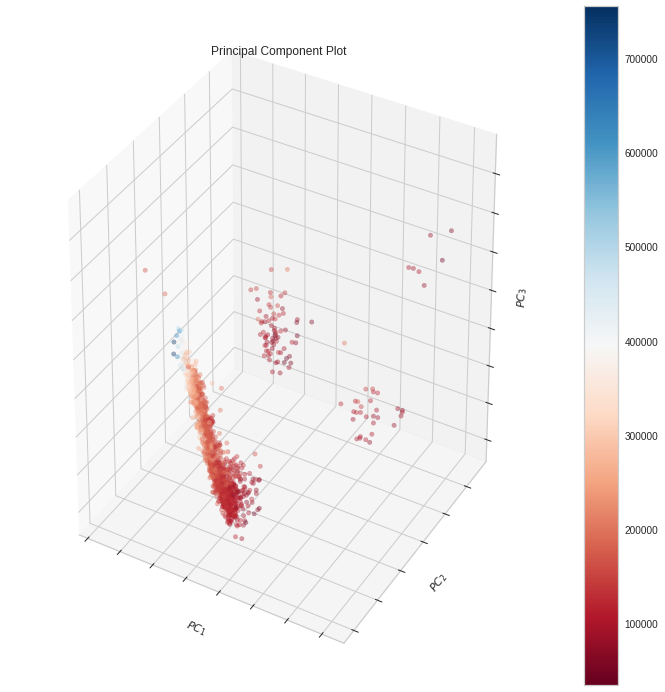

***
Box Plots
***


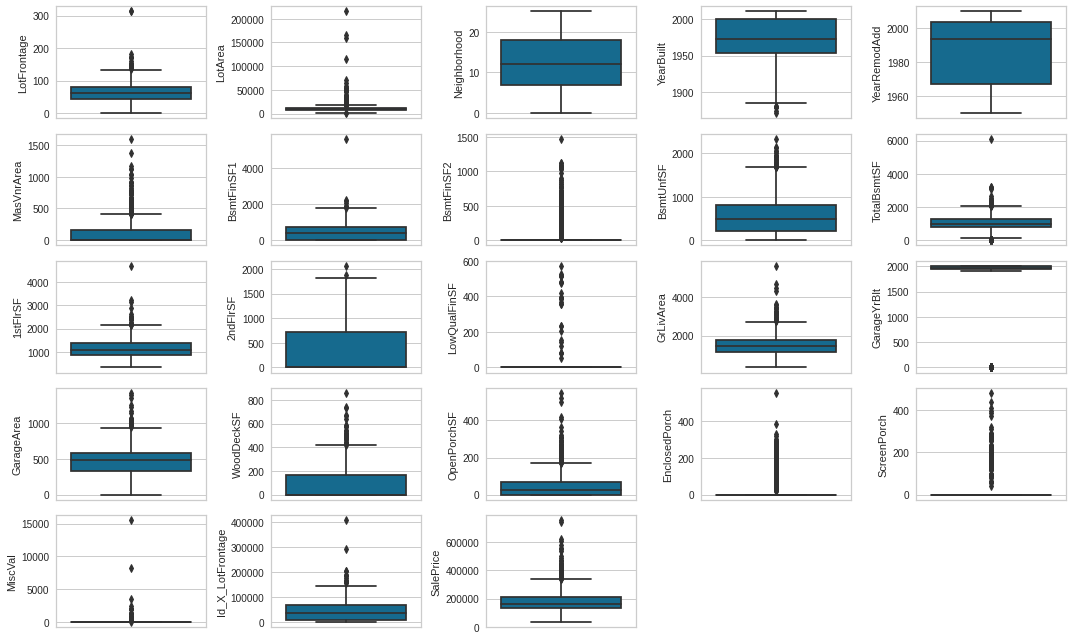

***
Line Plots
***


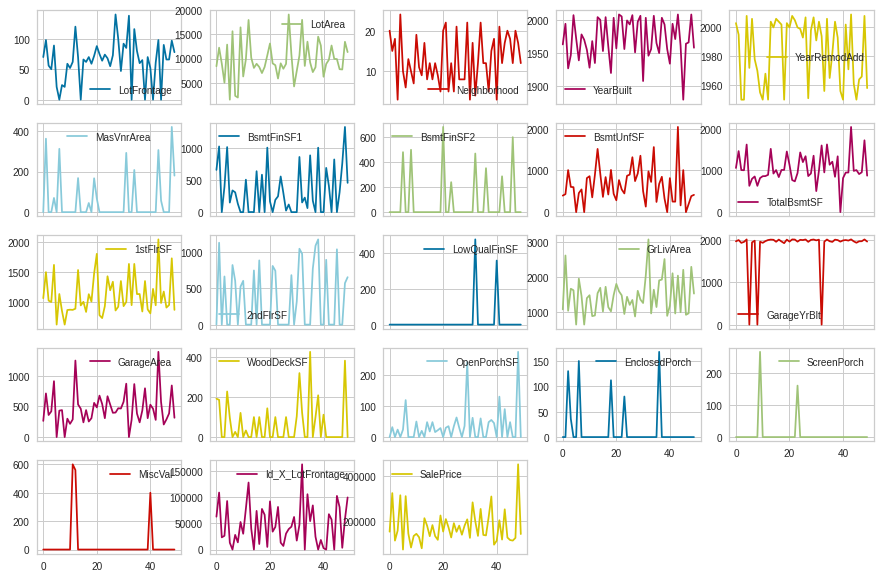

***
Correlations
***
Correlations with SalePrice:
SalePrice : 1.0
OverallQual : 0.7909816005838044
GrLivArea : 0.7086244776126523
GarageCars : 0.6404091972583529
GarageArea : 0.6234314389183618
TotalBsmtSF : 0.6135805515591956
1stFlrSF : 0.6058521846919147
ExterQual_TA : 0.5890435234097592
FullBath : 0.5606637627484449
BsmtQual_Ex : 0.5531048470089379


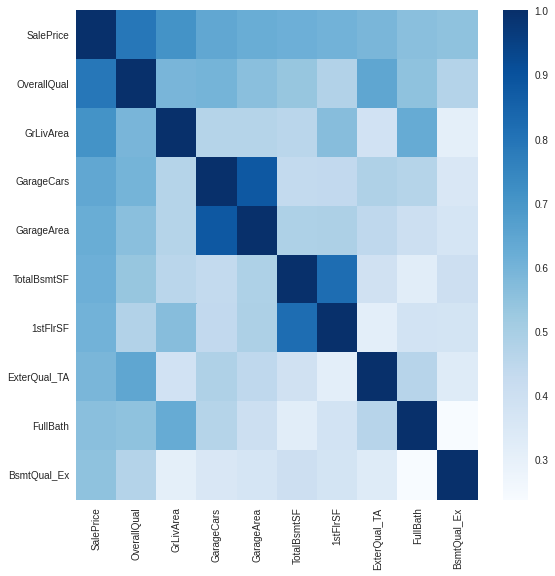

***
Pair Grid Plot
***
Correlations with SalePrice:
SalePrice : 1.0
OverallQual : 0.7909816005838044
GrLivArea : 0.7086244776126523
GarageCars : 0.6404091972583529
GarageArea : 0.6234314389183618


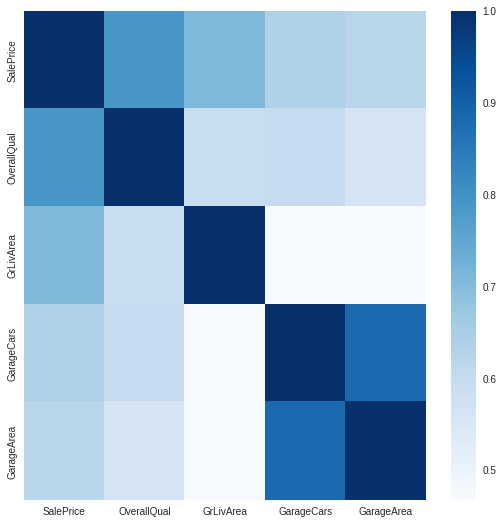

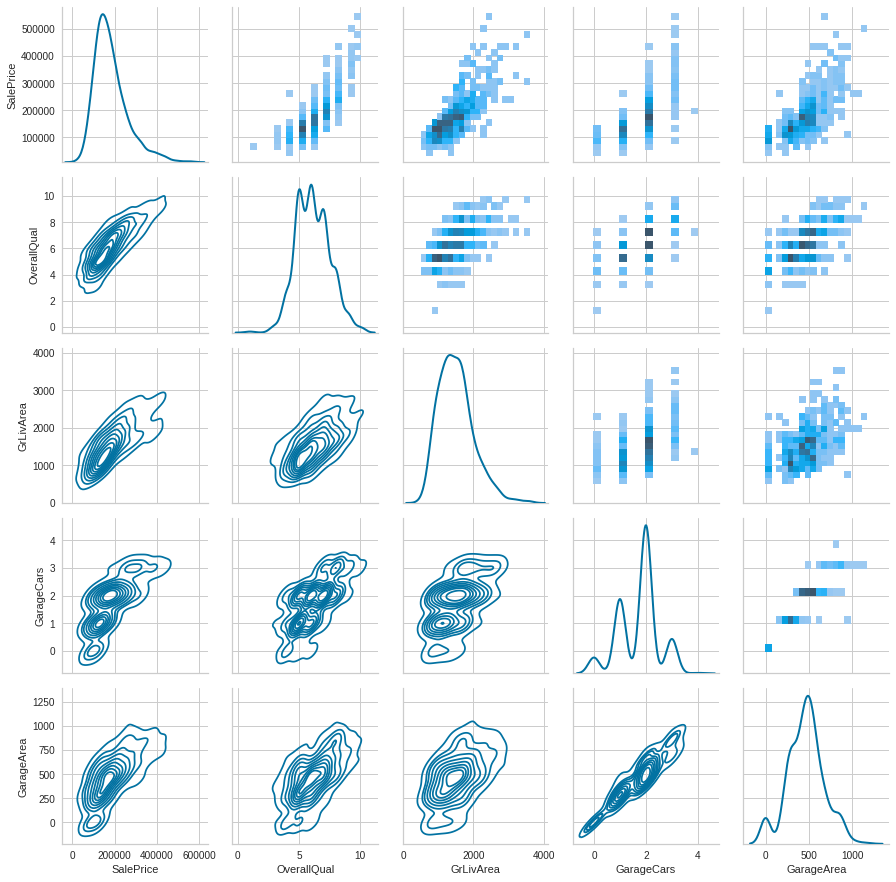

***
Decision Tree
***
|--- FullBath <= 1.50
|   |--- 1stFlrSF <= 1047.50
|   |   |--- class: 110000
|   |--- 1stFlrSF >  1047.50
|   |   |--- class: 140000
|--- FullBath >  1.50
|   |--- 3SsnPorch <= 355.50
|   |   |--- class: 190000
|   |--- 3SsnPorch >  355.50
|   |   |--- class: 180500

accuracy: 0.022602739726027398


In [8]:
#EDA
#Biểu thị dữ liệu của các thuộc tính với SalePrice và thể hiện mối liên quan giữa chúng
eda = rabbitml.eda()
eda.pipeline(Train_data,'SalePrice',fe,'regression')
display()

In [9]:
#Feature Selection
Train_data.head()

,MSSubClass,LotFrontage,LotArea,Street,Utilities,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,60,65.0,8450,1,0,5,7,5,2003,2003,...,0,0,1,0,0,0,0,1,0,208500
1,20,80.0,9600,1,0,25,6,8,1976,1976,...,0,0,1,0,0,0,0,1,0,181500
2,60,68.0,11250,1,0,5,7,5,2001,2002,...,0,0,1,0,0,0,0,1,0,223500
3,70,60.0,9550,1,0,6,7,5,1915,1970,...,0,0,1,1,0,0,0,0,0,140000
4,60,84.0,14260,1,0,15,8,5,2000,2000,...,0,0,1,0,0,0,0,1,0,250000


In [10]:
scaled_df = fe.quantile_transform_column_wise(Train_data, "SalePrice")
scaled_test_df = fe.quantile_transform_column_wise(Test_data, "SalePrice")
new_features = rabbitml.feature_selection.kendall_tau_feature_elimination(scaled_df, scaled_df.columns, "SalePrice", 0.001)
eliminated_df = scaled_df.copy()[new_features]
new_features.remove("SalePrice")
eliminated_test_df = scaled_test_df.copy()[new_features]
eliminated_df.head(1)

,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,Fence_0,Fence_GdWo,Fence_MnPrv,SaleType_COD,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,0.535035,0.349349,0.133634,0.734234,0.341341,0.795796,0.724224,0.79029,0.747748,0.176833,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,208500


In [19]:
#Prediction
from sklearn.metrics import mean_absolute_error
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def linear_regression_compare(X : np.ndarray, y : np.ndarray) -> typing.List:
    """
    Regress on the target col using a number of linear regressors

    Parameters
    ----------
    X : np.ndarray
        The features to use for regression
    y : np.ndarray
        The target to use the regression on

    Returns
    -------
    typing.List
        A list of regressor that have been fitted on the data provided
    """
    regressors = [("LinearRegression", linear_model.LinearRegression()), ("RidgeRegression", linear_model.Ridge()), ("Lasso", linear_model.Lasso(max_iter=4000)), ("ElasticNet", linear_model.ElasticNet()),("LassoLARS", linear_model.LassoLars(normalize=True)),("BayesianRidge", linear_model.BayesianRidge()), ("ARDRegression", linear_model.ARDRegression()), ("Stochastic Gradient Descent", linear_model.SGDRegressor())]

    regressor_results = []
    kfold = KFold(n_splits=5)
    for entry in regressors:
        name : str = entry[0]
        regressor = entry[1]
        scores = []
        rmse_scores = []
        for train_index, test_index in kfold.split(X, y):
            regressor.fit(X[train_index], y[train_index])
            scores.append(regressor.score(X[test_index], y[test_index]))
            rmse_scores.append(np.sqrt(mean_absolute_error(y[test_index], regressor.predict(X[test_index]))))
        regressor_results.append((regressor, (sum(scores) / len(scores))))
        print(name, "Score:", sum(scores) / len(scores))        
        print(name, "RMSE Accuracy:", sum(rmse_scores) / len(rmse_scores))        
        print("***")        
    return regressor_results
regressors = linear_regression_compare(eliminated_df.drop(columns="SalePrice").values, eliminated_df["SalePrice"])

LinearRegression Score: -4.154640384877008e+19
LinearRegression RMSE Accuracy: 2913396.2792924726
***
RidgeRegression Score: 0.8236902338915272
RidgeRegression RMSE Accuracy: 142.55461892933997
***
Lasso Score: 0.8198039549295244
Lasso RMSE Accuracy: 143.6832806789703
***
ElasticNet Score: 0.7164550277565346
ElasticNet RMSE Accuracy: 159.5578795203956
***
LassoLARS Score: 0.826914390767187
LassoLARS RMSE Accuracy: 141.36241487156695
***
BayesianRidge Score: 0.8285837057358829
BayesianRidge RMSE Accuracy: 140.61877057220028
***
ARDRegression Score: 0.8268697412297001
ARDRegression RMSE Accuracy: 141.2945644381854
***
Stochastic Gradient Descent Score: 0.8283353295472449
Stochastic Gradient Descent RMSE Accuracy: 141.30600003016025
***


In [18]:
# Sort List
regressors = sorted(regressors, key=lambda tup: tup[1], reverse=True)
regressor = regressors[0]
# regressor

(BayesianRidge(), 0.8285837057358829)

In [13]:
type(eliminated_df.drop(columns="SalePrice").values)

numpy.ndarray

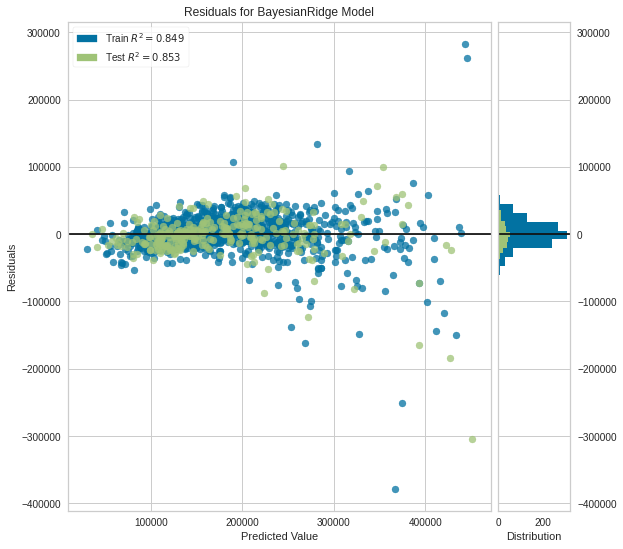

In [14]:
from yellowbrick.regressor import ResidualsPlot

def residuals_plot(model : BaseEstimator, X_train : np.ndarray, y_train : np.ndarray, X_test : np.ndarray, y_test : np.ndarray) -> None:
    """
    Create a residuals plot for a given model
    
    Parameters
    ----------
    model : BaseEstimator
        The trained regression model that will be used to make a regression model from
    X_train : np.ndarray
        The features to train against
    y_train : np.ndarray
        The target to train against
    X_test : np.ndarray
        The features to score against
    y_test : np.ndarray
        The target to score against
    """
    plt.rcParams["figure.figsize"] = (9,9)
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.show()                 # Finalize and render the figure

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(eliminated_df.drop(columns="SalePrice").values, eliminated_df["SalePrice"], test_size=0.2, random_state=42)
residuals_plot(regressor[0], X_train, y_train, X_test, y_test)

In [15]:
regressor[0].fit(eliminated_df.drop(columns="SalePrice").values, eliminated_df["SalePrice"])

BayesianRidge()

In [16]:
Sample_submission["SalePrice"] = regressor[0].predict(eliminated_test_df.values)
Sample_submission.to_csv("submission.csv", index=False)

In [17]:
#Kết quả submit
Sample_submission

,Id,SalePrice
0,1461,110554.136365
1,1462,179433.918222
2,1463,196990.180185
3,1464,207743.715574
4,1465,189419.381891
...,...,...
1454,2915,81642.728130
1455,2916,65418.278571
1456,2917,183628.853721
1457,2918,126836.338648
